In [1]:
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from matplotlib import pyplot
import numpy as np

Section - Setup

In [2]:
backend = AerSimulator()

key_len = 8  # for a local backend n can go as up as 23, after that it raises a Memory Error

qr = QuantumRegister(key_len, name='qr')
cr = ClassicalRegister(key_len, name='cr')

alice = QuantumCircuit(qr, cr, name="a") # Alice circuit
bob = QuantumCircuit(qr, cr, name="b") # Bob circuit

Section - Key generation

In [3]:
# Create alice secret key
alice_key = [1 if np.random.random() > 0.5 else 0 for i in range(key_len)]

# Encode key as alice qubits 
# IBM's qubits are all set to |0> initially
for index, digit in enumerate(alice_key):
    if digit == 1:
        alice.x(qr[index]) # if key has a '1', change state to |1>

Section - Basis Generation

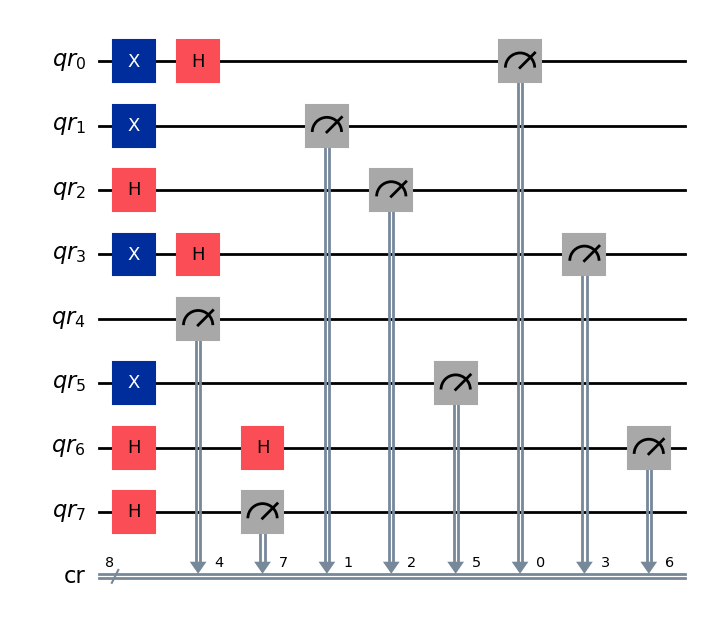

In [4]:
def create_basis(qc, qr):
    basis = []
    for index in range(key_len):
        if 0.5 < np.random.random():   # 50% chance
            qc.h(qr[index])    # change to diagonal basis
            basis.append(1)    # character for diagonal basis
        else:
            basis.append(0)
    return basis

# Create basis for Alice and Bob
alice_basis = create_basis(alice, qr)
bob_basis = create_basis(bob, qr)

alice_bob = alice.copy()
alice_bob.compose(bob, inplace=True)
for index in range(key_len): 
    alice_bob.measure(qr[index], cr[index])

alice_bob.draw("mpl")

Section - Key sharing

In [5]:
def run_circuit(circ):
    # Transpile circuit to work with the current backend.
    qc_compiled = transpile(circ, backend)
    # Run the job
    job_sim = backend.run(qc_compiled, shots=1)
    # Get the result
    result_sim = job_sim.result()
    return result_sim.get_counts()


def get_shared_key(key_a, key_b, basis_a, basis_b):
    acc = 0
    key_b = key_b[::-1]
    shared_idx = [] # Get the indexes of shared basis
    for idx, basis in enumerate(zip(basis_a, basis_b)):
        if basis[0] == basis[1]:
            shared_idx.append(idx)
        
    shared_key_a = [key_a[idx] for idx in shared_idx]
    shared_key_b = [int(key_b[idx]) for idx in shared_idx]
    for bit in zip(shared_key_a, shared_key_b):
        if bit[0] == bit[1]:
            acc += 1
    return (shared_key_a, shared_key_b, acc)

counts = run_circuit(alice_bob)

(shared_key_a, shared_key_b, acc) = get_shared_key(alice_key, next(iter(counts.keys())), alice_basis, bob_basis)

Section - Results

In [6]:
print(f"")
print(f"")
print(f"Pure Execution without Eve")
print(f"Alice shared key = {shared_key_a}")
print(f"Bob shared key   = {shared_key_b}")
print(f"Key sharing {"succeeded" if acc == len(shared_key_a) else  "failed"}")



Pure Execution without Eve
Alice shared key = [1, 0, 1, 0]
Bob shared key   = [1, 0, 1, 0]
Key sharing succeeded


Section - Eve Intercepting Alice

In [7]:
# Let introduce Eve to the circuit
eve = QuantumCircuit(qr, cr, name="c")
eve_basis = create_basis(eve, qr)

# First Alice send bit's to Eve
alice_eve = alice.copy()
alice_eve.compose(eve, inplace=True)
for index in range(key_len): 
    alice_eve.measure(qr[index], cr[index])

alice_eve.draw("mpl")
counts = run_circuit(alice_eve)

Section Eve Impersonating Alice

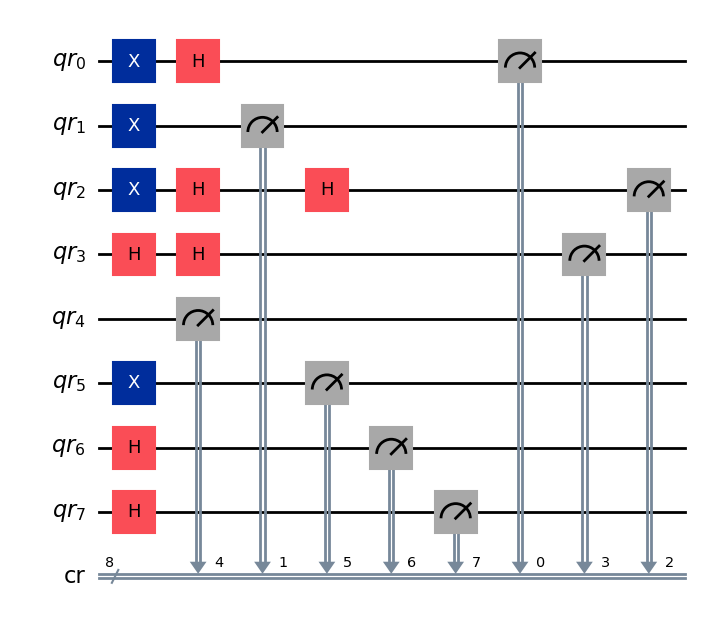

In [8]:
# Second Eve send bits to Bob.
# To achieve this we first recover Eve's state after measuring
eve_key = next(iter(counts.keys()))
eve_key_circ = QuantumCircuit(qr, cr, name="c")
for index, digit in enumerate(eve_key[::-1]):
    if digit == '1':
        eve_key_circ.x(qr[index])

eve_bob = eve_key_circ.copy()
eve_bob.compose(eve, inplace=True) # Append eve's basis 
eve_bob.compose(bob, inplace=True) # Append bob's basis
for index in range(key_len): 
    eve_bob.measure(qr[index], cr[index])

eve_bob.draw("mpl")

Section - Results with Eve

In [9]:
counts = run_circuit(eve_bob)
(shared_key_a, shared_key_b, acc) =  get_shared_key(alice_key, next(iter(counts.keys())), alice_basis, bob_basis)


print(f"Execution with Eve")
print(f"Alice's Basis = {alice_basis}")
print(f"Eve's Basis   = {eve_basis}")
print(f"Bob's Basis   = {bob_basis}")
print(f"Alice shared key = {shared_key_a}")
print(f"Bob shared key   = {shared_key_b}")
print(f"Key sharing {"succeeded Eve was not detected" if acc == len(shared_key_a) else  "failed Eve was detected"}")

Execution with Eve
Alice's Basis = [0, 0, 0, 0, 0, 0, 1, 0]
Eve's Basis   = [0, 0, 1, 1, 0, 0, 0, 0]
Bob's Basis   = [1, 0, 1, 1, 0, 0, 1, 1]
Alice shared key = [1, 0, 1, 0]
Bob shared key   = [1, 0, 1, 0]
Key sharing succeeded Eve was not detected
